In [1]:
from censai import RIMSharedUnetv3, PhysicalModelv2
from censai.models import SharedUnetModelv4
import tensorflow as tf
import json, os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.pylab as pylab
from astropy.visualization import SqrtStretch, imshow_norm, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import astropy.units as u
from astropy.wcs import WCS
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.Profiles.spep import SPEP
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Sampling.parameters import Param
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import matplotlib.pylab as pylab
import pandas as pd
import corner


plt.style.use("science")
params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':25}
pylab.rcParams.update(params)

# from reproject import reproject_interp

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180
%matplotlib inline
basepath = "/media/alexandre/Seagate/Ecole/Automne2021/Censai/"

# Preprocessing of the F814W image

In [ ]:
datapath = "../data/hst_mos_0043768_acs_wfc_f814w_drz.fits"
data = fits.open(datapath)

In [ ]:
wcs = WCS(data["SCI"].header)
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(image, cmap="gray_r", norm=ImageNormalize(interval=ZScaleInterval(), stretch=LogStretch()))

ax = plt.gca()
ax.set_xlabel('RA')
ax.set_ylabel('Dec');

In [ ]:
centroid = SkyCoord(172.96435966, -12.53284896, unit="deg")
centroid = centroid.to_pixel(wcs)
centroid

In [ ]:
size = 175 * u.pixel
cutout = Cutout2D(image, centroid, size, wcs=wcs)
cutout_image = cutout.data
wcs_cutout = cutout.wcs

In [ ]:
cutout = Cutout2D(weights, centroid, size, wcs=wcs)
cutout_weights = cutout.data

In [ ]:
mean, median, std = sigma_clipped_stats(cutout_image,  sigma=3.0)
print(mean, median, std)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(cutout_image)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

object_positions = sources[[7, 3, 1, 5, 4, 6]]["xcentroid", "ycentroid"].to_pandas().to_numpy() # B, A, C, D, G, S
ox, oy = object_positions[:, 0], object_positions[:, 1]

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs_cutout)
plt.imshow(cutout_image, cmap="gray_r", norm=ImageNormalize(interval=ZScaleInterval(), stretch=LogStretch()))
# plt.imshow(cutout_image > cutout_image.std())
ax = plt.gca()
ax.annotate("A",  [ox[1]-15, oy[1]], color="k", fontsize=20)
ax.annotate("B",  [ox[0]-15, oy[0]], color="k", fontsize=20)
ax.annotate("C",  [ox[2]-10, oy[2]], color="k", fontsize=20)
ax.annotate("D",  [ox[3], oy[3]-10], color="k", fontsize=20)
ax.annotate("G",  [ox[4], oy[4]-10], color="k", fontsize=20)
ax.annotate("S",  [ox[5], oy[5]+5], color="k", fontsize=20)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')


N, M = cutout_image.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
lens_sky = wcs_cutout.pixel_to_world(x.ravel(), y.ravel())
x = lens_sky.ra.to(u.arcsec) -  lens_sky.ra.min()
y = lens_sky.dec.to(u.arcsec) - lens_sky.dec.min()
width = x.max().value
deltaPix = (x[1] - x[0]).value
x_center = (x[M//2]).to(u.arcsec).value
y_center = (y[M*N//2]).to(u.arcsec).value

#scale bar
p0 = 30
dist = 1 / deltaPix
ax.plot([p0, p0 + dist], [10, 10], linewidth=2, color="k")
ax.text(p0 + dist / 2., 14, "1''", fontsize=15, color="k", ha='center')

#coordinate array
arrow_size = 0.01
color="k"
font_size = 15
width = 175
d0 = 10
p0 = 15
pt = 20

xx_, yy_ = (width - d0), d0
xx_ra, yy_ra = xx_ + p0, yy_
xx_dec, yy_dec = xx_, yy_ + p0
xx_ra_t, yy_ra_t = xx_ - pt, yy_
xx_dec_t, yy_dec_t = xx_, yy_ + pt

ax.arrow(xx_ , yy_, -(xx_ra - xx_), -(yy_ra - yy_),
         head_width=arrow_size * width, head_length=arrow_size * width, fc=color, ec=color, linewidth=1)
ax.text(xx_ra_t, yy_ra_t, "E", color=color, fontsize=font_size, ha='center')
ax.arrow(xx_, yy_, (xx_dec - xx_), (yy_dec - yy_),
         head_width=arrow_size * width, head_length=arrow_size * width, fc=color, ec=color, linewidth=1)
ax.text(xx_dec_t, yy_dec_t, "N", color=color, fontsize=font_size, ha='center')

ax.set_title("RXJ1131-1231")

In [ ]:
header = wcs_cutout.to_header()
header["EXPTIME"] = exptime
new_hdul = fits.HDUList()
new_hdul.append(fits.PrimaryHDU(data=cutout_image, header=header))
new_hdul.writeto(basepath + "data/rxj1131_cutout.fits", overwrite=True)

In [ ]:
noise_map = np.sqrt(np.maximum(residual, 0.) + exptime**2/cutout_weights)
new_hdul = fits.HDUList()
new_hdul.append(fits.PrimaryHDU(data=noise_map, header=wcs_cutout.to_header()))
new_hdul.writeto("../data/rxj1131_cutout_noise_map.fits", overwrite=True)

# Galfit of the lens light

In [ ]:
N = cutout_image.shape[1]
x = np.arange(N) - N//2
M = cutout_image.shape[0]
y = np.arange(M) - M//2
xx, yy = np.meshgrid(x, y)
rho = np.hypot(xx, yy)b

In [ ]:
plt.figure(figsize=(10, 10))
b_map = np.zeros_like(cutout_image)
b_map += (rho > 20) & (cutout_image > 0.4*std)
plt.imshow(cutout_image * (~b_map.astype(bool)), norm=ImageNormalize(stretch=LogStretch()), origin="lower", cmap="gray")
plt.axis("off")
plt.title("Mask")

In [ ]:
new_hdul = fits.HDUList()
new_hdul.append(fits.PrimaryHDU(data=b_map, header=wcs_cutout.to_header()))
new_hdul.writeto("../data/rxj1131_bad_pixel_map_galfit.fits", overwrite=True)

In [ ]:
new_hdul = fits.HDUList()
new_hdul.append(fits.PrimaryHDU(data=cutout_weights, header=wcs_cutout.to_header()))
new_hdul.writeto("../data/rxj1131_cutout_weights.fits", overwrite=True)

In [ ]:
# after galfit
block = fits.open(basepath + "/data/rxj1131_galfitted.fits")

# RIM prediction

In [2]:
phys = PhysicalModelv2( # use same parameter as was used during training, rescale kappa later
    pixels=175,
    kappa_pixels=128,
    src_pixels=128,
    image_fov=7.68,
    kappa_fov=7.68,
    src_fov=4,
    method="fft",
)

In [9]:
path = basepath + "/models/RIMSU128hstv4_augmented_003_K3_L5_BCL2_211124140837_continue_lr6e-05_211129202839"
with open(os.path.join(path, "unet_hparams.json")) as f:
    unet_params = json.load(f)
# unet_params["kernel_l2_amp"] = args.l2_amp
unet = SharedUnetModelv4(**unet_params)
ckpt = tf.train.Checkpoint(net=unet)
checkpoint_manager = tf.train.CheckpointManager(ckpt, path, 1)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()
with open(os.path.join(path, "rim_hparams.json")) as f:
    rim_params = json.load(f)
rim_params["source_link"] = "relu"
rim = RIMSharedUnetv3(phys, unet, **rim_params)

In [29]:
SNR = 5.098 # known from original fits file
sky_zero_point = -21.1 # mag
photflam = 6.9548454E-20 # inverse sensitivity ergs/cm2/Ang/electron
im = galfit_data[3].data
wcs= WCS(galfit_data[1].header)
psf = fits.open(basepath + "/data/rxj1131_psf1.fits")[0].data
psf2 = fits.open(basepath + "/data/tiny_psf00_psf.fits")[0].data
# noise_map = fits.open(basepath + "/data/rxj1131_cutout_noise_map.fits")[0].data
im[im < 0] = 0
# image_principales = np.loadtxt(basepath + "/data/images_positions.txt")[:4] ## B, A, C, D, G, S
f_vega = 8.60e-10 

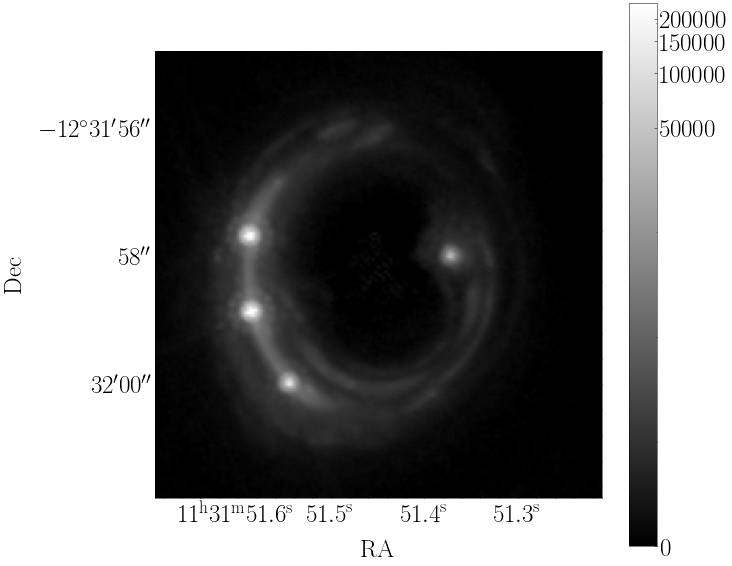

In [30]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(im, cmap="gray", norm=ImageNormalize(stretch=LogStretch()))#, norm=ImageNormalize(stretch=SqrtStretch()))
ax = plt.gca()
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.colorbar()

# Lenstronomy fit for comparison, follow Birrer 2017

In [12]:
path = basepath + "/data/rxj1131_galfitted.fits"
galfit_data = fits.open(path)
galfit_data.info()

Filename: /media/alexandre/Seagate/Ecole/Automne2021/Censai//data/rxj1131_galfitted.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (175, 175)   float32   
  1                1 ImageHDU        31   (175, 175)   float32   
  2                1 ImageHDU        50   (175, 175)   float32   
  3                1 ImageHDU         6   (175, 175)   float32   


In [24]:
# coordinate system in arcseconds, centered
N, M = im.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
lens_sky = wcs.pixel_to_world(x.ravel(), y.ravel())
x_center = (lens_sky.ra[M//2]).to(u.arcsec)
y_center = (lens_sky.dec[M*N//2]).to(u.arcsec)


# x_image = image_principales[:, 0] # B, A, C, D
# y_image = image_principales[:, 1]
# positions = wcs.pixel_to_world(x_image, y_image)
# x_image = (positions.ra - lens_sky.ra.max()).to(u.arcsec).value
# y_image = (positions.dec - lens_sky.dec.min()).to(u.arcsec).value
# image_position = pd.DataFrame(np.column_stack([x_image, y_image]), columns=["theta_x", "theta_y"])
# image_position

In [28]:
# data specifics for the lens image
# sigma_bkg = .05  #  background noise per pixel (Gaussian)
# exp_time = 1.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
delta_pix_x = np.abs(lens_sky.ra[0] - lens_sky.ra[1]).to(u.arcsec).value
delta_pix_y = np.abs(lens_sky.dec[0] - lens_sky.dec[M]).to(u.arcsec).value
kwargs_data = {
    "image_data": im, 
    "exposure_time": exp_time, 
    "background_rms": sigma_bkg, # white noise approximation, careful from understimation here
    "noise_map": noise_map, # drizzling weights
               "transform_pix2angle":np.array([[-delta_pix_x, 0], [0, delta_pix_y]]),
               "ra_at_xy_0": 0,
               "dec_at_xy_0": 0
               }
data_class = ImageData(**kwargs_data)

In [ ]:
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image}]
#                            'point_amp': np.abs(mag)*1000}]  
point_source_list = ['LENSED_POSITION']
# point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

In [ ]:
kwargs_psf = {'psf_type': "PIXEL", "kernel_point_source":psf, "pixel_size": delta_pix_x}

In [ ]:
fixed_lens = [{}, {'ra_0': x_center, 'dec_0': y_center}]
fixed_lens_light = [{}, {}, {}]
fixed_source = [{}, {}]
fixed_ps = [{}]

kwargs_lens_init = [
    {'theta_E': 1.5, 'e1': 0.1, 'e2': 0.1, 'gamma': 2, 'center_x': x_center, 'center_y': y_center}, # SPEP
    {'gamma1': 0., 'gamma2': 0.}] # Shear

# Start from value known from galfitting
kwargs_lens_light_init = [
    {}, # Sersic 1 for main deflector G
    {}, # sersic 2 for main deflector G
    {}  # Small satellite S
]

kwargs_source_init = [
    {'R_sersic': 1, 'n_sersic': 4., 'e1': 0, 'e2': 0, 'center_x': x_center, 'center_y': y_center}, # bulge
    {'R_sersic': 1, 'n_sersic': 1., 'e1': 0., 'e2': 0., 'center_x': x_center, 'center_y': y_center} # disc
]
# kwargs_source_init = [{'amp': 1, 'beta': 0.2, 'n_max': 7, 'center_x': x_center, 'center_y': y_center}]
kwargs_ps_init = [{'ra_image': x_image, 'dec_image': y_image}]

# initial spread in parameter estimation
kwargs_lens_sigma = [
    {'theta_E': 0.3, 'e1': 0.1, 'e2': 0.1, 'gamma': .2, 'center_x': 0.1, 'center_y': 0.1},
    {'gamma1': 0.1, 'gamma2': 0.1}
]
kwargs_lens_light_sigma = [
    {},
    {},
    {}
]
kwargs_source_sigma = [
    {'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2},
    {'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2}
]
# kwargs_source_sigma = [{'amp': 0.1, 'beta': 0.2, 'n_max': 0, 'center_x': 0.2, 'center_y': 0.2}]
kwargs_ps_sigma = [{ 'ra_image': [0.02] * 4, 'dec_image': [0.02] * 4}]

# hard bound lower limit in parameter space 
kwargs_lower_lens = [
    {'theta_E': 0.5, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': x.min().value, 'center_y': y.min().value},
    {'gamma1': -0.5, 'gamma2': -0.5}
]
kwargs_lower_lens_light = [
    {},
    {},
    {}
]
kwargs_lower_source = [
    {'R_sersic': 0.04, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': x_center-2, 'center_y': y_center-2},
    {'R_sersic': 0.04, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': x_center-2, 'center_y': y_center-2}
]
# kwargs_lower_source = [{'amp': 0, 'beta': 0.2, 'n_max': 0, 'center_x': x.min().value, 'center_y': y.min().value}]
kwargs_lower_ps = [{'ra_image': (x_center-5) * np.ones_like(x_image), 'dec_image': (x_center-5) * np.ones_like(y_image)}]

# hard bound upper limit in parameter space 
kwargs_upper_lens = [
    {'theta_E': 5, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': x.max().value, 'center_y': y.max().value},
    {'gamma1': 0.5, 'gamma2': 0.5}
]
kwargs_upper_lens_light = [
    {},
    {},
    {}
]
kwargs_upper_source = [
    {'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': x_center+2, 'center_y': y_center+2},
    {'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': x_center+2, 'center_y': y_center+2}
]
# kwargs_upper_source = [{'amp': 10, 'beta': 100, 'n_max': 30, 'center_x': x.max().value, 'center_y': y.max().value}]
kwargs_upper_ps = [{'ra_image': (x_center+5) * np.ones_like(x_image), 'dec_image': (y_center+5) * np.ones_like(y_image)}]


lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]
lens_light_params [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]
source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

In [ ]:
plate_scale = (delta_pix_x + delta_pix_y)/2
plate_scale

In [ ]:
fixed_special = {}
kwargs_special_init = {}
kwargs_special_sigma = {}
kwargs_lower_special = {}
kwargs_upper_special = {}

# Quasar represented as point source
fixed_special['source_size'] = source_size_arcsec
kwargs_special_init['source_size'] = source_size_arcsec
kwargs_special_sigma['source_size'] = source_size_arcsec
kwargs_lower_special['source_size'] = 0.0001 # arcsec
kwargs_upper_special['source_size'] = 0.1

# For cosmography
# kwargs_special_init['D_dt']= 5000
# kwargs_special_sigma['D_dt'] = 1000
# kwargs_lower_special['D_dt'] = 100
# kwargs_upper_special['D_dt'] =  10000
special_params = [kwargs_special_init, kwargs_special_sigma, fixed_special, kwargs_lower_special, kwargs_upper_special]


window_size = 0.1  # units of arcseconds
grid_number = 100  # supersampled window (per axis)
kwargs_flux_compute = {
    'source_type': 'INF',  # you can either chose 'INF' which is a infinetesimal source sice, 'GAUSSIAN' or 'TORUS'
    'window_size': window_size, # window size to compute the finite source magnification (only when 'GAUSSIAN' or 'TORUS' are chosen.)
    'grid_number': grid_number
} 


source_model_list = ['SERSIC_ELLIPSE']*2 # default bulge + disc
# source_model_list = ["SHAPELETS"] # free form source reconstruction, regularized by number of shapelet used
lens_light_model_list = ['SERSIC_ELIPSE']*2 + ['PSF']
lens_model_list = ['SPEP', 'SHEAR']

kwargs_params = {
    'lens_model': lens_params,
    'source_model': source_params,
    'lens_light_model': lens_light_params,
    'point_source_model': ps_params,
    'special': special_params}

kwargs_model = {
    'lens_model_list': lens_model_list, 
    'lens_light_model_list': lens_light_model_list,
    'source_light_model_list': source_model_list,
    'point_source_model_list': point_source_list
}

In [ ]:
# observation = tf.constant(residual / residual.max(), dtype=tf.float32)[None, ..., None]
# lens_light = tf.constant(model, dtype=tf.float32)[None, ..., None]
# rim_input1 = tf.constant(rim_input, dtype=tf.float32)[None, ..., None]
# psf1 = tf.constant(psf, dtype=tf.float32)[None, ..., None]
# noise_rms = tf.constant(std_bkg / residual.max())[None] # same scaling as before  --> make sure rim call support the sigma image
# mask1 = tf.constant(mask, dtype=tf.float32)[None, ..., None]